In [1]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy import fftpack, ndimage
import cv2

ModuleNotFoundError: No module named 'cv2'

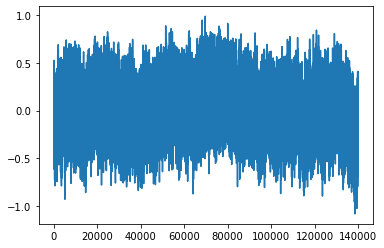

In [3]:
file_name = "noise3.wav"
rate, sig = wav.read("audio/"+file_name)
sig = (sig - sig.mean()) / sig.max()
plt.plot(sig)
plt.show()

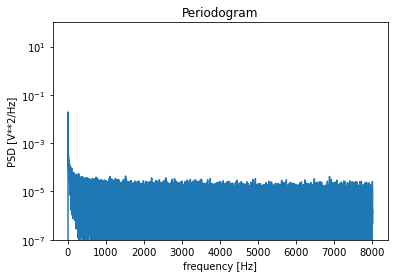

In [4]:
f, Pxx_den = signal.periodogram(sig, rate)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Periodogram')
plt.show()

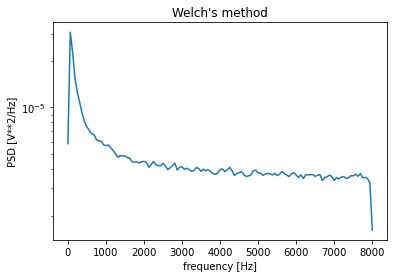

In [5]:
f, Pxx_den = signal.welch(sig, rate)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title("Welch's method")
plt.show()

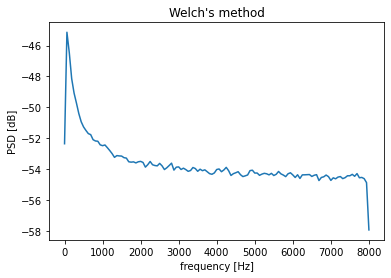

In [6]:
# plot in dB
plt.plot(f, 10 * np.log10(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [dB]')
plt.title("Welch's method")
plt.show()

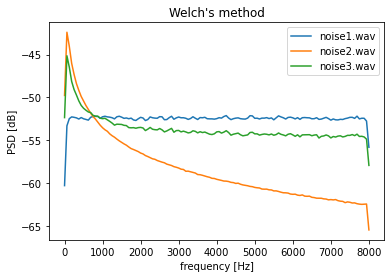

In [7]:
# read 3 noise files and plot their PSD in dB side by side
file_names = ["noise1.wav", "noise2.wav", "noise3.wav"]
for file_name in file_names:
    rate, sig = wav.read(file_name)
    sig = (sig - sig.mean()) / sig.max()
    f, Pxx_den = signal.welch(sig, rate)
    plt.plot(f, 10 * np.log10(Pxx_den), label=file_name)
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [dB]')
plt.title("Welch's method")
plt.show()

- TODO: He suggested to recognize noise just visually 

# Image

Read "barabara image" and normalize it to [0, 1] range.

In [8]:
img = cv2.imread('barbara.jpg', cv2.IMREAD_GRAYSCALE)
img = (img - img.min()) / (img.max() - img.min())

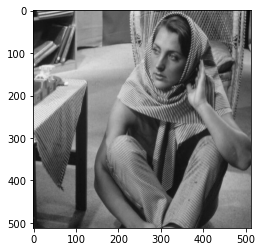

In [9]:
# read barbara.jpg image and plot it
plt.imshow(img, cmap='gray')
plt.show()

### Generate noisy image with different noise SNR values

SNR formula is defined as:

$$
\begin{align}
SNR &= \frac{||x||_2^2}{||x - x_{noisy}||_2^2} \\
x_{noisy} &= x + n, \quad n \sim \mathcal{N}(0, \sigma^2) \\
\end{align}
$$
For the Gaussian noise:

$$
SNR = 10 \log_{10} \left( \frac{\sigma^2}{\sigma_n^2} \right)
$$

where $\sigma$ is the standard deviation of the original image, and $\sigma_n$ is the standard deviation of the noise.

To get the noise standard deviation, with given SNR, we extract the noise standard deviation from the SNR formula:

$$
\sigma_n^2 = \frac{\sigma^2}{10^{\frac{SNR}{10}}}
$$

Example with SNR=5

In [10]:
SNR = 5
img_var = np.var(img)
noise_var_sq = img_var/10**(SNR/10)
noise_std = np.sqrt(noise_var_sq)

In [11]:
# generate white noise with noise_std and add it to the image
noise = noise_std*np.random.normal(0, 1, img.shape)

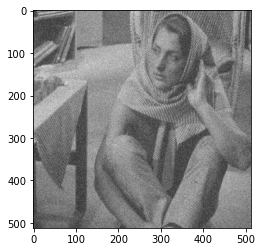

In [12]:
img_noisy = img + noise
plt.imshow(img_noisy, cmap='gray')
plt.show()

In [13]:
# calculate SNR between img_noisy and img to verify that it is 5 dB
img_noisy_var = np.var(img - img_noisy)
SNR = 10*np.log10(img_var/img_noisy_var)
SNR


4.981264642599867

Now we generate noisy image with different SNR values and plot them side by side to compare. As we can see, the higher the SNR, the more similar the noisy image is to the original image.  
As expected, SNR=0 is mostly unrecognizable.

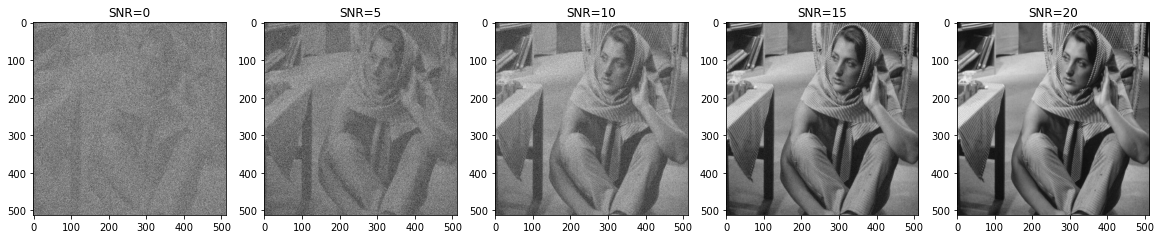

In [14]:
SNR_LIST = [0, 5, 10, 15, 20]
# create subplots for each SNR
fig, axs = plt.subplots(1, len(SNR_LIST), figsize=(20, 5))
for i, SNR in enumerate(SNR_LIST):
    # add noise to image
    noise = np.random.normal(0, 1 / (10 ** (SNR / 10)), img.shape)
    noisy_img = img + noise
    # plot noisy image
    axs[i].imshow(noisy_img, cmap='gray')
    axs[i].set_title(f"SNR={SNR}")
plt.show()


### Denoise with Wiener filter

Given that noise is Gaussian, we can define the Wiener filter as:

$$
\hat{h} = \frac{P_x}{P_x + \sigma_{noise}^2}
$$

where P_x is the power spectrum of the original image. We can estimate the power spectrum of the original image with periodogram:

$$
P_x = \frac{1}{N} \sum_{k=1}^N |X_k|^2
$$

where $N$ is the number of pixels in the image, and $X_k$ is the $k$-th Fourier coefficient of the image.


To get the denoised image, we convolve the noisy image with the Wiener filter:

$$
x_{est} = h * x_{noisy}
$$

In [15]:
n = img.shape[0]
N = n**2
# power spectrum of the image by periodogram
P = 1/N * abs(fftpack.fft2(img))**2

Compute the approximate Wiener filter.

In [16]:
h_w = fftpack.ifft2( P / ( P + noise_std**2 ) )

In [17]:
h_w = np.real(h_w)

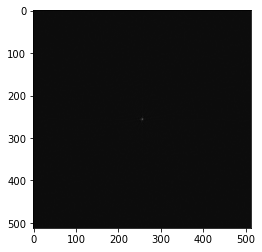

In [18]:
# plot fftshift of h_w
plt.imshow(np.fft.fftshift(h_w), cmap='gray')
plt.show()

In [19]:
def cconv(a, b):
    return np.real(fftpack.ifft2(fftpack.fft2(a)*fftpack.fft2(b)))

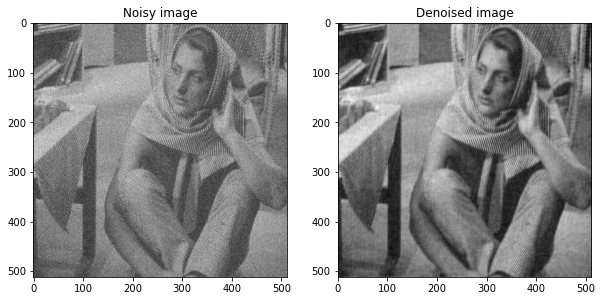

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_noisy, cmap='gray')
axs[0].set_title("Noisy image")
axs[1].imshow(cconv(img_noisy, h_w), cmap='gray')
axs[1].set_title("Denoised image")

plt.show()

We should take into the account that usually we don't know the power spectrum of the original image. We can estimate it with periodogram, but it is not very accurate. So, we can use the power spectrum of the noisy image instead. This is called the "blind" Wiener filter.

## Noised music

Same story but with 1D signal. The only difference is that we use 1d fft.

read audio file and noises:

In [28]:
noise_file_names = ["noise1.wav", "noise2.wav", "noise3.wav"]
music_file_name = "music.wav"

# Simulate a noisy version of the music using the three noises using a global factor of 0.1 for each noise
rate, music = wav.read(music_file_name)
music = (music - music.mean()) / music.max()

noisy_musics = {}
noises = {}
for file_name in noise_file_names:
    rate, sig = wav.read(file_name)
    sig = (sig - sig.mean()) / sig.max()
    noises[file_name] = sig
    # add noise to music
    noisy_musics[file_name] = music + 0.1*sig

noisy_musics

{'noise1.wav': array([-0.02327404, -0.00396558, -0.00136716, ..., -0.06977666,
         0.02884573, -0.00325645]),
 'noise2.wav': array([-0.01092202, -0.0271295 , -0.04883574, ..., -0.06181331,
        -0.0076709 ,  0.01292441]),
 'noise3.wav': array([-0.02793222, -0.01999099, -0.0296657 , ..., -0.07447401,
         0.01354115, -0.01385066])}

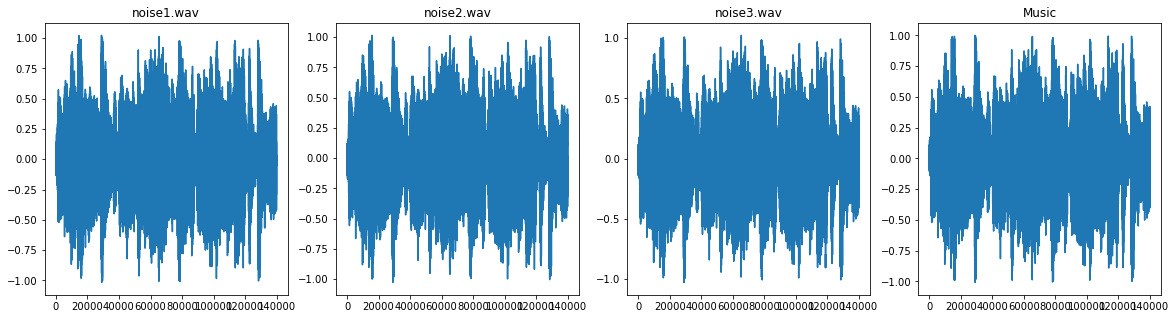

In [29]:
# plot noisy music
fig, axs = plt.subplots(1, len(noisy_musics)+1, figsize=(20, 5))
for i, file_name in enumerate(noisy_musics):
    axs[i].plot(noisy_musics[file_name])
    axs[i].set_title(file_name)
    
axs[-1].plot(music)
axs[-1].set_title("Music")
plt.show()

In [30]:
# listen to noisy music in notebook
from IPython.display import Audio
Audio(noisy_musics["noise2.wav"], rate=rate)

### Wiener filter

In [31]:
noisy_music = noisy_musics["noise2.wav"]
noise = noises["noise2.wav"]

In [32]:
N = len(noisy_music)
P = 1/N * abs(fftpack.fft(music))**2;

In [33]:
sigma = np.std(noise)
h_w = np.real(fftpack.ifft( P / ( P + sigma**2 ) ) );

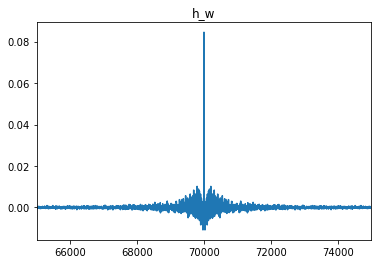

In [35]:
# plot the filter
plt.plot(fftpack.fftshift(h_w))
# set x and y limits
plt.xlim([65000, 75000])
plt.title("h_w")
plt.show()

In [36]:
def cconv(a, b):
    return np.real(fftpack.ifft(fftpack.fft(a)*fftpack.fft(b)))

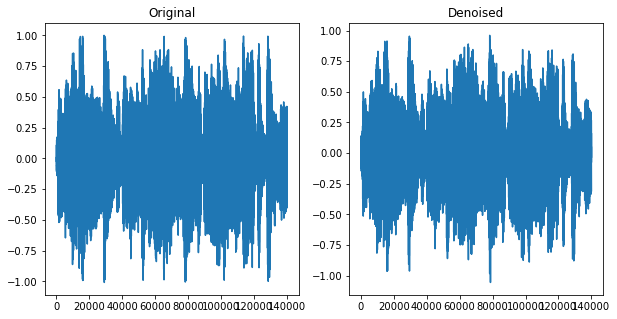

In [37]:
music_denoised = cconv(noisy_music, h_w)

# plot noisy music and denoised music in the same plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(music)
# set title
axs[0].set_title("Original")
axs[1].plot(music_denoised)
# set title
axs[1].set_title("Denoised")
plt.show()

In [38]:
# play denoised music
Audio(noisy_music, rate=rate)

In [39]:
# play denoised music
Audio(music_denoised, rate=rate)

In [40]:
# play denoised music
Audio(music, rate=rate)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba11df0e-dfa2-4154-9aed-10842feb179c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>